In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one, ode_y_jump_approach_one_boundary
from model import uncertainty_decomposition
from utilities import find_nearest_value
from numba import njit

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

**ODE for y on (0, 2)**:
\begin{align*}
0 = &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
&+ (\eta-1)(\gamma_1 + \gamma_2 y)\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h)\\
& + (\eta-1)\left[\frac{1}{2}\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)\right]|\sigma_y|^2(\tilde{e})^2\\
& +\frac{\xi_{1,m}}{2}h^\prime h + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
\end{align*}


#### 1. minimize over $h$:

The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y )\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e}\sum_{i=1}^n \pi^c_i\theta_i + \frac{1}{2} \left(F(y)-\frac{G^2(y)}{\xi_{1,m}}\right)|\sigma_y|^2(\tilde{e})^2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
\end{align*}

where $G(y):=\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y)$, $F(y):=\frac{d^2 \phi(y)}{(d y)^2} + (\eta-1)\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)$.

#### 2. minimize over $\pi^c$:
The FOC of $\pi^c_i$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^c_i
$$

#### 3. minimize over $g$:
Change the boundary condition for the value matching problem.

#### 4. marginal value of emission

\begin{align*}
ME = & - \frac{d\phi(y)}{dy}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h) - \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})\\
& - (\eta-1)(\gamma_1 + \gamma_2 y)(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h)\\
& - (\eta-1)\gamma_2|\sigma_y|^2\tilde{e}\\
\end{align*}


In [14]:
def solve_ME(ξ_w, ξ_p, ξ_a, baseline_w, baseline_p, baseline_a):
    η = .032
    δ = .01

    θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
    πc_o = np.ones_like(θ)/len(θ)
    σ_y = 1.2*1.86/1000

    y_bar = 2.
    γ_1 = 1.7675/10000
    γ_2 = .0022*2

    # Three damage model
    γ_2p = np.array([0, .0197*2, .3853*2])
    πd_o = np.array([1./3, 1./3, 1./3])

    y_step = .02
    y_grid_long = np.arange(0., 4., y_step)
    y_grid_short = np.arange(0., 2+y_step, y_step)
    n_bar = find_nearest_value(y_grid_long, y_bar) + 1

    # Prepare ϕ_i
    ϕ_list = []
    for γ_2p_i in γ_2p:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                           tol=1e-8, max_iter=10_000, print_all=False)
        ϕ_list.append(model_res['v0'])

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = ϕ_i[:n_bar]
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    ς = .25
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                                 v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                 ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)

    ME_total = δ*η/model_res['e_tilde']

    # Uncertainty decomposition
    model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
    
    if baseline_w:
        h = np.zeros_like(model_res['h'])
    else:
        h = None
    if baseline_p:
        bc = np.average(ϕ_i, weights=πd_o, axis=0)[-1]
    else:
        bc = None
    if baseline_a:
        πc = np.ones_like(model_res['πc'])/len(θ)
    else:
        πc = None

    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=h, πc=πc, bc=bc,
                                              v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)  
    ME_part = model_res_new['ME']
    return ME_total, ME_part

In [13]:
ME_total, ME_part = solve_ME(ξ_w=1./400, ξ_p=1./20, ξ_a=1./10000, baseline_w=True, baseline_p=True, baseline_a=True)

Converged. Total iteration 2872: LHS Error: 7.600674992169765e-09; RHS Error 7.404157770928184e-07
Converged. Total iteration 2080: LHS Error: 9.987384703979973e-09; RHS Error 4.568585821608658e-06
Converged. Total iteration 2311: LHS Error: 9.980335058390466e-09; RHS Error 2.1073026151569218e-05
Converged. Total iteration 541: LHS Error: 9.971400455333068e-09; RHS Error 9.031098519281602e-06
Converged. Total iteration 682: LHS Error: 9.9538790682141e-09; RHS Error 7.188511370350835e-06


(0.0, 1.0)

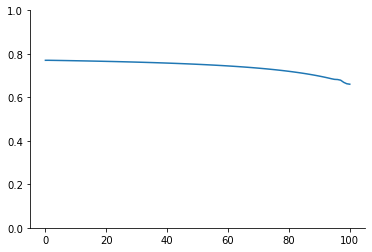

(101,)